## Input vs output timeseries 

Code to compare input and output timeseries for tilted_v 

In [1]:
import pfio
import numpy as np
from numpy import genfromtxt
import math
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm

np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

In [2]:
## read in csv of input signal
Signal = genfromtxt('/Users/abramfarley/ParF/uahpc/tilted_v_layered/signal_layered.csv', delimiter=',')
print(Signal)

[2.85647111e-04 2.88058012e-04 2.88804164e-04 3.01297039e-04
 3.02979589e-04 3.05973838e-04 3.09110439e-04 3.16904888e-04
 3.19185758e-04 3.24217015e-04 3.28408133e-04 3.34674264e-04
 3.38026273e-04 3.41810406e-04 3.44005168e-04 3.54142562e-04
 3.57393066e-04 3.60341510e-04 3.64026182e-04 3.65803788e-04
 3.72029048e-04 3.75294992e-04 3.76988249e-04 3.79899216e-04
 3.83791826e-04 3.85567923e-04 3.89075476e-04 3.95710500e-04
 3.96669287e-04 4.02584555e-04 4.05922700e-04 4.07497222e-04
 4.12729419e-04 4.16234231e-04 4.18262692e-04 4.19658926e-04
 4.25904658e-04 4.26701239e-04 4.27891549e-04 4.30921021e-04
 4.32199453e-04 4.34286979e-04 4.37461484e-04 4.38144475e-04
 4.40594298e-04 4.41473240e-04 4.42830053e-04 4.43509139e-04
 4.44397846e-04 4.47510712e-04 4.49106538e-04 4.49816002e-04
 4.50020736e-04 4.50980435e-04 4.52179034e-04 4.53029422e-04
 4.53646458e-04 4.54451177e-04 4.53662394e-04 4.53157130e-04
 4.54080280e-04 4.55037786e-04 4.56735581e-04 4.52987537e-04
 4.52915968e-04 4.529165

In [3]:
dx = 10
dy = 10
dz = 0.25
z = 2.5

input = Signal[0:5000] #/ z   

In [4]:
X_Range = list(range(0,200))
X_Range_Long = list(range(0,5000))

In [5]:
print(type(X_Range),len(X_Range))

<class 'list'> 200


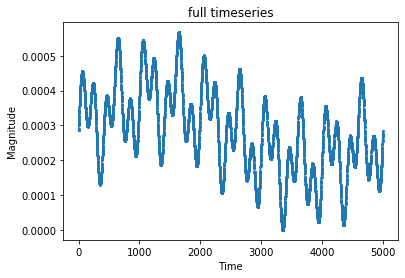

In [6]:
# Plotting the series
plt.plot(X_Range_Long, Signal, marker='.', markersize=4)
#plt.plot(irregular_tie_samples2, samples2, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('full timeseries');

Text(0, 0.5, 'Input Signal (m/d)')

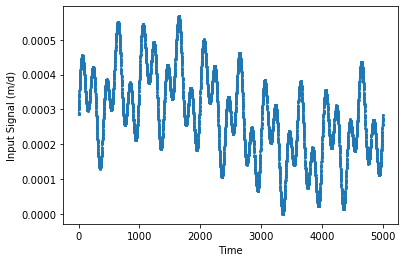

In [7]:
# Plotting the series
plt.plot(X_Range_Long, input, marker='.', markersize=4)
#plt.plot(irregular_time_samples2, samples2, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Input Signal (m/d)')
#plt.title('first 200 inputs');

In [8]:
### dimensions and intial conditions
Porosity = pfio.pfread('/Users/abramfarley/ParF/uahpc/tilted_v_layered/tilted_v_layered_dz/tilted_v_layered_dz.out.porosity.pfb')
nx = Porosity.shape[2]
nz = Porosity.shape[0]
ny = Porosity.shape[1]

Porosity.shape

(10, 5, 15)

In [9]:
Slopey = 0.05
Cell_Volume = dx*dy*dz
Mannings = 3*10**(-6)
Spec_Stor = pfio.pfread('/Users/abramfarley/ParF/uahpc/tilted_v_layered/tilted_v_layered_dz/tilted_v_layered_dz.out.specific_storage.pfb')
Porosity = pfio.pfread('/Users/abramfarley/ParF/uahpc/tilted_v_layered/tilted_v_layered_dz/tilted_v_layered_dz.out.porosity.pfb')

In [10]:
## slopes are only written out as a silo file, need loop to set slopex based on the x value
Slopex = []
for i in range(nx):
    if i < 7:
        Slopex.append(-0.01)
    elif i == 7:
        Slopex.append(0.0)
    else:
        Slopex.append(0.01)
print(Slopex)

[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


## overflow calculations
calculate the overflow out of domain

In [11]:
## precip time series
Qin = []

for i in range(len(input)):
    area = dx*dy*nx*ny        #top layer surface area
    precip = input[i] * area  #volumetric flux into domain
    Qin.append(precip)
#print(Qin)

In [12]:
surface_storage_ls = []
groundwater_storage = []
Qout_ls = []
outflow_ls = []
delta_S_ls = []
change_substorage_ls = []
change_sufstorage_ls = []
change_storage_actual = []
subsurface_storage = []
sbs_t = 0
surf_t = 0
Initial_Surf_Storage = None    #nothing assigned (will be filled or will be set to zero in conditional statment)
Initial_Subsurf_Storage = None #nothing assigned (will be filled or will be set to zero in conditional statment)


press_topleft = []
press_topmid = []
press_botleft = []
press_botmid = []
for t in range(len(input)):
    saturation = pfio.pfread('/Users/abramfarley/ParF/uahpc/tilted_v_layered/tilted_v_layered_dz/tilted_v_layered_dz.out.satur.{:05}.pfb'.format(t))
    pressure = pfio.pfread('/Users/abramfarley/ParF/uahpc/tilted_v_layered/tilted_v_layered_dz/tilted_v_layered_dz.out.press.{:05}.pfb'.format(t))
    
    if pressure[nz-1,0,0] > 0:
        press_topleft.append(pressure[nz-1,0,0])
    else:
        press_topleft.append(0)
        
    if pressure[nz-1,0,7] > 0:
        press_topmid.append(pressure[nz-1,0,7])
    else:
        press_topmid.append(0)
        
    if pressure[nz-1,4,0] > 0:
        press_botleft.append(pressure[nz-1,4,0])
    else:
        press_botleft.append(0)
        
    if pressure[nz-1,4,7] > 0:
        press_botmid.append(pressure[nz-1,4,7])
    else:
        press_botmid.append(0)
    
    #subsurface storage calculation
    gws = (saturation == 1.0) * Cell_Volume *(Porosity + (pressure * Spec_Stor))
    sbs = saturation*Cell_Volume*(Porosity + (pressure * Spec_Stor))
    
    #initialize variables
    temp_sbs = 0
    total_gws = 0
    temp_gws = 0
    total_sbs = 0
    Qout_x = 0
    Qout_y = 0
    outflow = 0
    total_surface_storage = 0
    temp_surface_storage = 0
    surface_storage = []

    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                
                temp_sbs = sbs[k,j,i]
                total_sbs = total_sbs + temp_sbs
                
                temp_gws = gws[k,j,i]
                total_gws = total_gws + temp_gws
                
                if t == 0:
                    Initial_Subsurf_Storage = total_sbs
                if Initial_Subsurf_Storage is None:
                    Initial_Subsurf_Storage = 0
            
                if j == ny-1 and k == nz-1:   #if at the base of the v
                    sfmag = ((Slopex[i])**2 + Slopey**2)**0.5
                    outflow_t = ((max(pressure[k,j,i],0)**(5.0/3.0)) * Slopey / (sfmag ** 0.5) / Mannings) *dx
                    Qy_t = (math.sqrt(abs(Slopey))/Mannings)*(max(pressure[k,j,i],0)**(5.0/3.0)) * dx
                    Qout_y = Qout_y + Qy_t
                    outflow = outflow + outflow_t
                     
                if k == nz - 1 and pressure[nz-1,j,i] > 0.0:
                    temp_surface_storage = pressure[nz-1,j,i] * dx * dy
                    total_surface_storage = total_surface_storage + temp_surface_storage
                    if t == 0:
                        Initial_Surf_Storage = total_surface_storage
                        
                if Initial_Surf_Storage is None:
                    Initial_Surf_Storage = 0
                    print('no water on top')
    #print(total_surface_storage)
    surface_storage_ls.append(total_surface_storage)                
    #Storage Calcuations and appending to their respective lists
    #print(outflow)
    delta_S = Qin[t] - outflow    #m3/day
    delta_S_ls.append(delta_S)
    #surface_storage.append(total_surface_storage)
    groundwater_storage.append(total_gws)
    Qout_tot = Qout_x + Qout_y
    Qout_ls.append(Qout_tot)
    outflow_ls.append(outflow)
    
    
    #print((surface_storage))
    subsurface_storage.append(total_sbs)
    
    #print(t,'subsurface storage:', int(total_sbs), 'surface storage is:', int(total_surface_storage), 'runoff', int(outflow))
    if t == 0:
        change_substorage = (total_sbs - Initial_Subsurf_Storage)   #divide my dt (1 day)
        change_substorage_ls.append(change_substorage)
        change_suf = (total_surface_storage - Initial_Surf_Storage)  
        change_sufstorage_ls.append(change_suf)
        change_storage_actual.append(change_suf+change_substorage)
        
    else:    
        change_substorage = (total_sbs - sbs_t)   
        change_substorage_ls.append(change_substorage)
        change_suf = (total_surface_storage - surf_t)  
        change_sufstorage_ls.append(change_suf)
        change_storage_actual.append(change_suf+change_substorage)
    
    sbs_t = total_sbs    #reset the t-1 timestep variables
    surf_t = total_surface_storage


no water on top


In [13]:
print(Initial_Subsurf_Storage, Initial_Surf_Storage)

5329.911633238108 0


In [14]:
print(change_storage_actual)

[0.0, 2.142353334116706, 2.16043508868097, 2.1660312329240696, 2.2597277902523274, 2.2723469178608866, 2.294803781191149, 2.3183282897653044, 2.3767866565340228, 2.3938931843258615, 2.4316276099134484, 2.4630610010108285, 2.5100569835494753, 2.5351970496012655, 2.563578042973859, 2.5800387577801303, 2.6560692118910083, 2.6804479938427903, 2.7025613215828344, 2.730196362062088, 2.743528412368505, 2.7902178622107385, 2.8147124372480903, 2.8274118698254824, 2.849244121214724, 2.8784386979596093, 2.8917594220556566, 2.9180660712290774, 2.967828746824125, 2.975019650480135, 3.0193841617174257, 3.0444202498883897, 3.0562291624319187, 3.095470641871543, 3.1217567379644606, 3.13697019002484, 3.147441948906817, 3.1942849284723707, 3.200259292465489, 3.2091866192895395, 3.2319076608409887, 3.241495899178517, 3.257152344463975, 3.2809611309912725, 3.2860835615538235, 3.3044572365697604, 3.3110493024742027, 3.3212253980818787, 3.326318543036905, 3.332983847009018, 3.3563303431692475, 3.36829903660

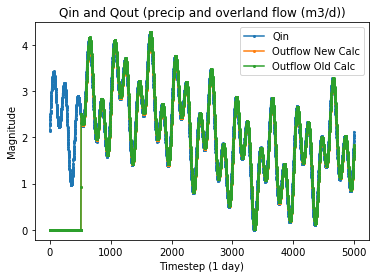

In [15]:
plt.plot(X_Range_Long, Qin, marker='.', markersize=4, label="Qin")
#plt.plot(x_range, Qout_ls, marker='o', markersize=4, label="Qout")
plt.plot(X_Range_Long, outflow_ls, marker='.', markersize=4, label="Outflow New Calc")
plt.plot(X_Range_Long, Qout_ls, marker='.', markersize=4, label="Outflow Old Calc")
#plt.plot(irregular_time_samples2, samples2, marker='o', markersize=4)
plt.xlabel('Timestep (1 day)')
plt.ylabel('Magnitude')
plt.title('Qin and Qout (precip and overland flow (m3/d))')
plt.legend(loc="upper right")
plt.savefig('Qin_out_moredamped.png')

In [16]:
## in vs out:
sum_in = 0
sum_out = 0

for i in range(len(input)):
    sum_in = sum_in + Qin[i]
    sum_out = sum_out + Qout_ls[i]
print(sum_in, sum_out)
#print(Qin/np.asarray(outflow_ls))

10635.84116547698 9476.433419619578


In [17]:
##pressure at four corners
#print(press_topleft)

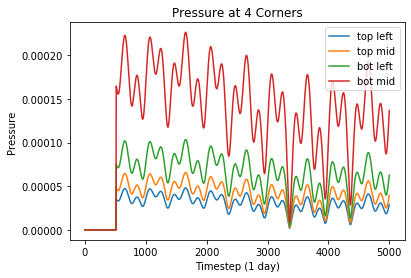

In [18]:
plt.plot(X_Range_Long, press_topleft, label = "top left")
plt.plot(X_Range_Long, press_topmid, label = "top mid")
plt.plot(X_Range_Long, press_botleft, label = "bot left")
plt.plot(X_Range_Long, press_botmid, label = "bot mid")

plt.xlabel('Timestep (1 day)')
plt.ylabel('Pressure')
plt.title('Pressure at 4 Corners')

plt.legend(loc="upper right")
#plt.savefig('pressure_moredamped.png')



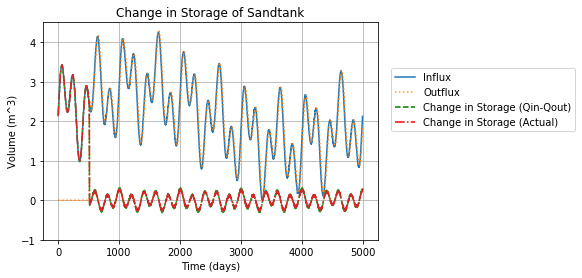

In [19]:
#time = list(range(0,runtime))
#x = time     #[175:275]
y1 = Qin  #[175:275]
y2 = Qout_ls #[175:275]
y3 = delta_S_ls #[175:275]
y4 = change_storage_actual #[175:275]

plt.plot(X_Range_Long, y1, linestyle='-')
plt.plot(X_Range_Long, y2, linestyle=':')
plt.plot(X_Range_Long, y3, linestyle='--')
plt.plot(X_Range_Long[1:5000], y4[1:5000], linestyle='-.')

plt.title('Change in Storage of Sandtank')
plt.xlabel('Time (days)')
plt.ylabel('Volume (m^3)')
plt.ylim((-1, 4.5))

#lengend of the 4 lines
dash_line = mlines.Line2D([], [], linestyle='-', label='Influx')
dot_line = mlines.Line2D([], [], color ='orange', linestyle=':', label='Outflux')
doubledash_line = mlines.Line2D([], [], color = 'green', linestyle='--', label='Change in Storage (Qin-Qout)')
dashdot_line = mlines.Line2D([], [], color = 'red', linestyle='-.', label='Change in Storage (Actual)')
plt.legend(loc=(1.04,0.5), handles=[dash_line, dot_line, doubledash_line, dashdot_line])

plt.grid(True)

Text(0, 0.5, 'Timestep')

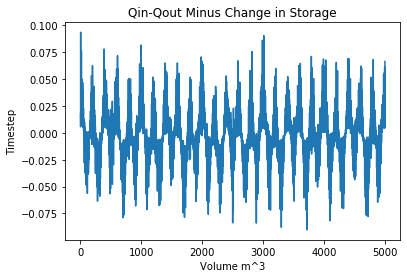

In [20]:

plt.plot(X_Range_Long[1:5000], np.asarray(y3)[1:5000]-np.asarray(y4)[1:5000])
plt.title('Qin-Qout Minus Change in Storage')
plt.xlabel('Volume m^3')
plt.ylabel('Timestep')


In [21]:
#print(change_sufstorage_ls)

In [22]:
#print(change_substorage_ls)

(6560, 6600)

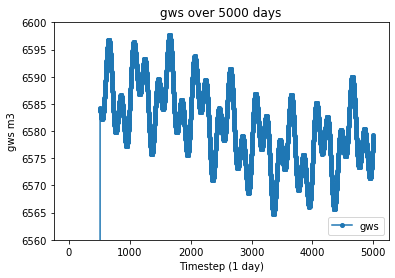

In [23]:
plt.plot(X_Range_Long, groundwater_storage, marker='o', markersize=4, label="gws")
plt.xlabel('Timestep (1 day)')
plt.ylabel('gws m3')
plt.title('gws over 5000 days')
plt.legend(loc="lower right")
plt.ylim(6560,6600)

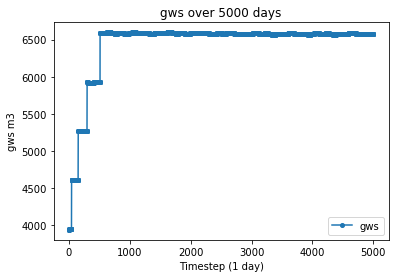

In [24]:
plt.plot(X_Range_Long, groundwater_storage, marker='o', markersize=4, label="gws")
plt.xlabel('Timestep (1 day)')
plt.ylabel('gws m3')
plt.title('gws over 5000 days')
plt.legend(loc="lower right")


In [25]:
print(type(surface_storage))
print(len(surface_storage_ls))

<class 'list'>
5000


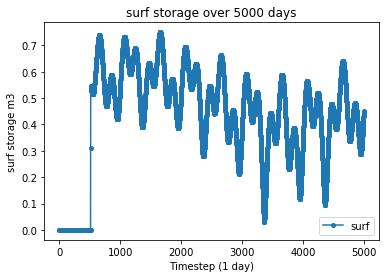

In [26]:
plt.plot(X_Range_Long, surface_storage_ls, marker='o', markersize=4, label= "surf")
plt.xlabel('Timestep (1 day)')
plt.ylabel('surf storage m3')
plt.title('surf storage over 5000 days')
plt.legend(loc="lower right")

In [27]:
print(saturation.shape)

(10, 5, 15)


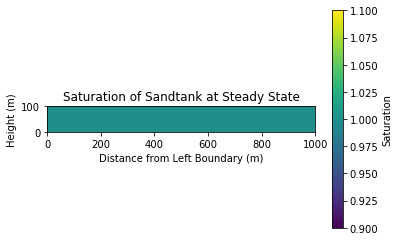

In [28]:
#plt.figure(3)  #imoshow plot of saturation at final timestep

sat_2d = np.reshape(saturation[nz-1,:,:], (5,15)) #remove y dimension
plt.imshow(sat_2d, origin="lower", extent=(0, 1000, 0, 100))
plt.title('Saturation of Sandtank at Steady State')
plt.xlabel('Distance from Left Boundary (m)')
plt.ylabel('Height (m)')
cb = plt.colorbar()
cb.set_label('Saturation')

# plt.figure(4)   #imoshow plot of Pressure at final timestep

# press_2d = np.reshape(pressure, (100,100))  #remove y dimension
# plt.imshow(press_2d, origin="lower", extent=(0, 1000, 0, 100))
# plt.title('Pressure of Sandtank at Steady State')
# plt.xlabel('Distance from Left Boundary (m)')
# plt.ylabel('Height (m)')
# cb = plt.colorbar()
# cb.set_label('Pressue')

# #plt.show()

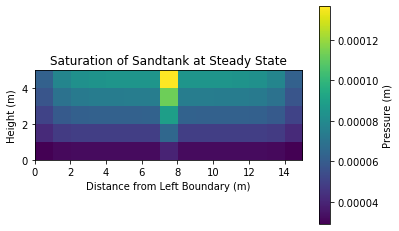

In [29]:
press_2d = np.reshape(pressure[nz-1,:,:], (5,15)) #remove y dimension
plt.imshow(press_2d, origin="lower", extent=(0, 15, 0, 5))
plt.title('Saturation of Sandtank at Steady State')
plt.xlabel('Distance from Left Boundary (m)')
plt.ylabel('Height (m)')
cb = plt.colorbar()
cb.set_label('Pressure (m)')